# Transfer Learning with TensorFlow Part 1: Feature Extraction 

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.


In [1]:
# Are we using a GPU?
!nvidia-smi

Sat Jun 12 23:07:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.76       Driver Version: 470.76       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A    0C    P8    N/A /  N/A |     37MiB /  2048MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data 

In [2]:
# # Get the data (10% of 10 food classes from Food101)
# import zipfile

# # Download the data
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2021-06-12 23:11:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.67.176, 142.250.67.208, 142.250.76.176, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.67.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: '10_food_classes_10_percent.zip'

     0K .......... .......... .......... .......... ..........  0%  163K 16m52s
    50K .......... .......... .......... .......... ..........  0% 71.6M 8m27s
   100K .......... .......... .......... .......... ..........  0% 81.8M 5m39s
   150K .......... .......... .......... .......... ..........  0% 1.07M 4m52s
   200K .......... .......... .......... .......... ..........  0% 4.05M 4m1s
   250K .......... .......... .......... .......... ..........  0% 4.71M 3m27s
   300K .......... .......... .......... .......... ..........  0% 1.

In [3]:
# # Unzip he downloaded
# zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
# zip_ref.extractall()
# zip_ref.close()

In [4]:
# How many images in each folder ?
import os

# Walk through 10% data derectory and list number of files 
for dirpath, dirname, filenames in os.walk('10_food_classes_10_percent'):
    print(f'There are {len(dirname)} directories and {len(filenames)} inmage in "{dirpath}".')

There are 2 directories and 0 inmage in "10_food_classes_10_percent".
There are 10 directories and 0 inmage in "10_food_classes_10_percent\test".
There are 0 directories and 250 inmage in "10_food_classes_10_percent\test\chicken_curry".
There are 0 directories and 250 inmage in "10_food_classes_10_percent\test\chicken_wings".
There are 0 directories and 250 inmage in "10_food_classes_10_percent\test\fried_rice".
There are 0 directories and 250 inmage in "10_food_classes_10_percent\test\grilled_salmon".
There are 0 directories and 250 inmage in "10_food_classes_10_percent\test\hamburger".
There are 0 directories and 250 inmage in "10_food_classes_10_percent\test\ice_cream".
There are 0 directories and 250 inmage in "10_food_classes_10_percent\test\pizza".
There are 0 directories and 250 inmage in "10_food_classes_10_percent\test\ramen".
There are 0 directories and 250 inmage in "10_food_classes_10_percent\test\steak".
There are 0 directories and 250 inmage in "10_food_classes_10_percent

## Creating data loaders (preparing the data) 

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [6]:
# Setup data inputs
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print('Training images:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir, 
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical',
                                                          seed=42)
print('Testing images:')
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        seed=42)

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks: 

* Tracking experiments with the `TensorBoard` callback 
* Model checkpoint with the `ModelCheckpoint` callback 
* Stopping a model from training (before it trains too long and over-fitting) with the `EarlyStopping` callback 

In [8]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f'Saving TensorBoard log files to: {log_dir}')
    return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pre-trained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [9]:
# Let's compare the following two models
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [10]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub

In [19]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
    '''
    Takes a TensorFlow Hub URL and creates a keras Sequential model with it.
    
    Args:
        model_url (str): A TensorFlow Hub feature extraction URL.
        num_classes (int): Number of output neurons in the output layer,
                           should be equal to number of target classes, default 10.
                           
    Returns:
        An uncompiled Keras Sequential model with model_url as feature extractor 
        layer and Dense output layer with num_classes output neurons.
    '''
    # Download the pretrained model and save it as a Keras layer 
    feature_extractor_layer = hub.KerasLayer(model_url, 
                                             trainable=False, # freeze the already learned patterns
                                             name='feature_extraction_layer',
                                             input_shape=IMAGE_SHAPE+(3,))
    # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        tf.keras.layers.Dense(num_classes, activation='softmax', name='output_layer')
    ])
    
    # Compile the model
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])
    
    return model

### Creating and Testing ResNet TensorFlow Hub Feature Extraction model

In [24]:
# Create Resnet model 
resnet_model = create_model(resnet_url, 
                            num_classes=train_data_10_percent.num_classes)

In [25]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [26]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
history_resnet = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                         experiment_name='resnet50v2')])

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20210613-133643
Epoch 1/5
24/24 [==============================] - 110s 5s/step - loss: 1.8664 - accuracy: 0.3560 - val_loss: 1.1398 - val_accuracy: 0.6536
Epoch 2/5
24/24 [==============================] - 97s 4s/step - loss: 0.8817 - accuracy: 0.7440 - val_loss: 0.8348 - val_accuracy: 0.7324
Epoch 3/5
24/24 [==============================] - 97s 4s/step - loss: 0.6134 - accuracy: 0.8187 - val_loss: 0.7447 - val_accuracy: 0.7708
Epoch 4/5
24/24 [==============================] - 97s 4s/step - loss: 0.4719 - accuracy: 0.8827 - val_loss: 0.6880 - val_accuracy: 0.7820
Epoch 5/5
24/24 [==============================] - 105s 5s/step - loss: 0.3819 - accuracy: 0.9013 - val_loss: 0.6728 - val_accuracy: 0.7816


In [27]:
# Import libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.style.use('dark_background')

In [28]:
# Plot the validation and training curves seprately
def plot_loss_curves(history_):
    '''
    Returns separate loss curves for training and validation metrics.
    
    Args:
        history: TensorFlow History object.
        
    Returns:
        Polts of training/validation loss and accuracy metrics.
    '''
    loss = history_.history['loss']
    val_loss = history_.history['val_loss']
    
    accuracy = history_.history['accuracy']
    val_accuracy = history_.history['val_accuracy']
    
    epochs = range(len(history_.history['loss'])) # How many epochs did we run for?
    
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training_loss')
    plt.plot(epochs, val_loss, label='Val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Accuracy')
    plt.plot(epochs, val_accuracy, label='Val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

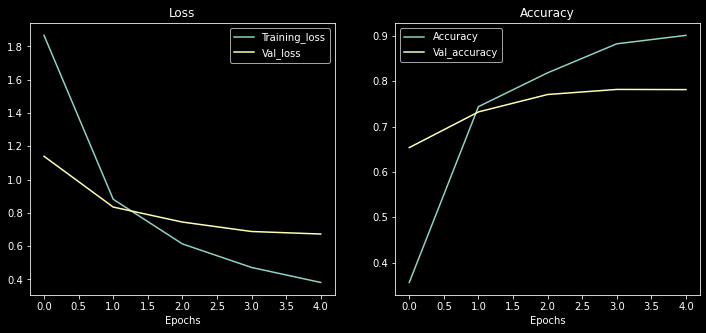

In [29]:
plot_loss_curves(history_resnet)

### Create and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

Read information about [EfficientNetB0](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html)

In [30]:
# Create the model
efficientnet_model = create_model(efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

In [31]:
# Get model Summary
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [32]:
# Fit the model 
history_efficientnet = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data_10_percent,
                                              validation_steps=len(test_data_10_percent),
                                              callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                     experiment_name='efficientnetb0')])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20210613-140134
Epoch 1/5
24/24 [==============================] - 116s 4s/step - loss: 1.8243 - accuracy: 0.4507 - val_loss: 1.2641 - val_accuracy: 0.7440
Epoch 2/5
24/24 [==============================] - 71s 3s/step - loss: 1.0510 - accuracy: 0.7733 - val_loss: 0.8557 - val_accuracy: 0.8292
Epoch 3/5
24/24 [==============================] - 71s 3s/step - loss: 0.7575 - accuracy: 0.8373 - val_loss: 0.6864 - val_accuracy: 0.8508
Epoch 4/5
24/24 [==============================] - 71s 3s/step - loss: 0.6076 - accuracy: 0.8653 - val_loss: 0.6020 - val_accuracy: 0.8616
Epoch 5/5
24/24 [==============================] - 71s 3s/step - loss: 0.5141 - accuracy: 0.8907 - val_loss: 0.5513 - val_accuracy: 0.8676


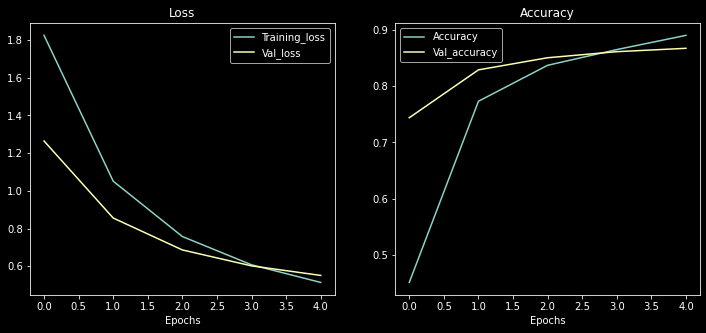

In [33]:
# PLot loss curves
plot_loss_curves(history_efficientnet)

In [36]:
# How many layers does our efficientnetb0 feature extraction have?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning 

- **"As is" transfer learning :** Using an existing model with no changes what so ever (e.g. using `ImageNet` model on 1000 `ImageNet` classes, none of your own problem)
- **"Feature extraction" transfer learning :** Use the pre-learned patterns of an existing model (e.g. `EfficientNetB0` trained on `ImageNet`) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
- **"Fine-tuning" transfer learning :** Use the pre-learned patterns of an existing model and `'fine-tune'` many or all of the underlying layers (including new output layers).

## Comparing our model results using TensorBoard

> **Note :** When you upload things to [TensorBoard.dev](https://tensorboard.dev/), you experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to [TensorBoard.dev](https://tensorboard.dev/).

In [47]:
# # Upload TensorBoard dev records
# !tensorboard dev --upload --logdir ./tensorflow_hub/ \
# --name "EfficientNetB0 vs. ResNet50V2" 
# --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
# --one_shot

SyntaxError: invalid syntax (<ipython-input-47-563b4627b9d3>, line 3)

In [48]:
# # check out what TensorBoard experiments you have
# !tensorboard dev list

^C


In [49]:
# # Delete an experiment
# !tensorboard dev delete --experiment_id _______________ # In this black you have to copy experiments id...

^C


In [50]:
# # Confirm the deletion by re-checking what experiments you have left
# !tensorboard dev list